## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

### Preprocessing Data

In [2]:
def preprocess_data(file_path):
    # Load data
    data = pd.read_csv(file_path, na_values=['N/a'])
    
    # Select key performance metrics for player clustering
    features = [
        'Goals', 'Assists', 'Minutes', 'Expected Goals', 
        'Goals Scored per 90 minutes', 'Assists per 90 minutes',
        'Shots on target per 90 minutes', 'Progressive Carries in Progression',
        'Progressive Passes in Progression', 'Pass Completion Percentage',
        'Tackles', 'Interceptions', 'Blocks'
    ]
    
    players = data[['Player', 'Position', 'Team'] + features].copy()
    
    for col in features:
        players[col] = players[col].apply(lambda x: float(str(x).replace(',', '')) if isinstance(x, str) else x)
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(players[features])
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return players, X_scaled, features

In [3]:
players, X_scaled, features = preprocess_data('results.csv')
print(f"Loaded data for {len(players)} players with {len(features)} features")


Loaded data for 490 players with 13 features


### Find Optimal Number of Clusters


In [5]:
def find_optimal_k(X, max_k=10, random_state=42, n_init=10):
    inertia = []
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
        # Calculate silhouette score
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)
    
    # Plot Elbow Method and Silhouette Scores
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Method')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"K-Means.png")
    plt.show()
    
    diffs = np.diff(inertia)
    elbow_point = np.argmax(np.diff(diffs)) + 2
    
    best_silhouette_k = np.argmax(silhouette_scores) + 2
    
    return {
        'elbow_k': elbow_point,
        'silhouette_k': best_silhouette_k,
        'best_k': max(3, min((elbow_point + best_silhouette_k) // 2, 7)),
        'silhouette_scores': silhouette_scores
    }

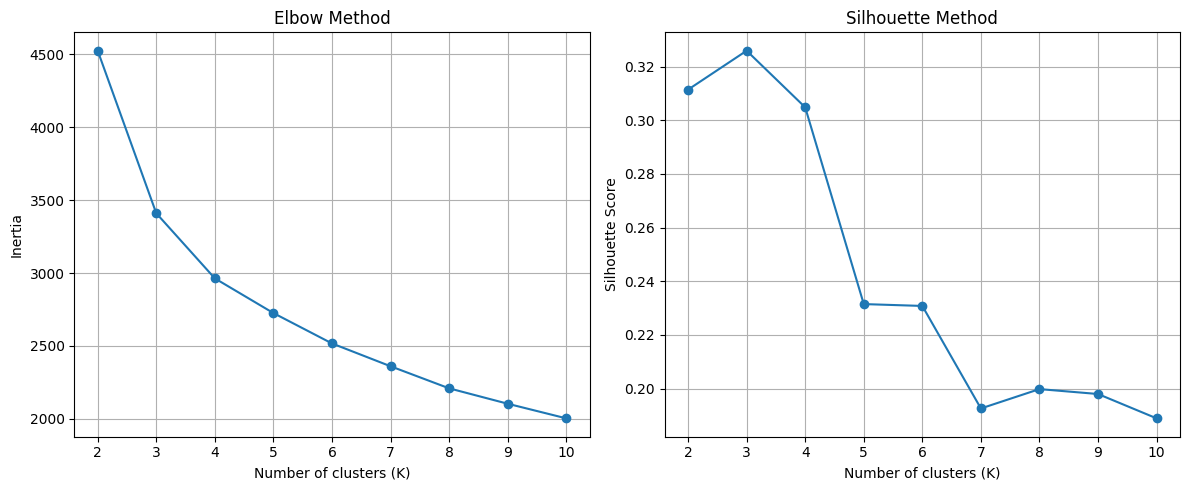

Optimal number of clusters: 3


In [6]:
k_results = find_optimal_k(X_scaled)
k = k_results['best_k']
print(f"Optimal number of clusters: {k}")


In [7]:
def interpret_silhouette(score):
    if score > 0.7: return "Very well separated clusters"
    elif score > 0.5: return "Well separated clusters"
    elif score > 0.3: return "Reasonable structure found"
    else: return "Clusters overlap considerably"


In [9]:
def analyze_clusters_summary(players, features, labels, k, k_results):
    players_with_clusters = players.copy()
    players_with_clusters['Cluster'] = labels
    
    position_by_cluster = {}
    for i in range(k):
        cluster_players = players_with_clusters[players_with_clusters['Cluster'] == i]
        position_counts = cluster_players['Position'].value_counts().head(3)
        position_by_cluster[i] = [f"{pos} ({count})" for pos, count in position_counts.items()]
    
    players_with_clusters.to_csv('players_clustered.csv', index=False)
    
    elbow_k = k_results['elbow_k']
    silhouette_k = k_results['silhouette_k']
    
    print("\n----- CLUSTER ANALYSIS RESULT -----")
    print(f"Optimal number of clusters: {k}")
    print(f"Edlbow method suggested: {elbow_k} clusters")
    print(f"Silhouette method suggested: {silhouette_k} clusters")
    
    print("\nRATIONALE FOR CLUSTER SELECTION:")
    print(f"The players should be classified into {k} groups because:")
    if elbow_k == silhouette_k:
        print(f"- Both the elbow method and silhouette analysis strongly agree on {k} clusters")
    else:
        print(f"- The elbow method indicated {elbow_k} clusters (where adding more clusters stops providing significant benefit)")
        print(f"- The silhouette analysis indicated {silhouette_k} clusters (optimal separation between clusters)")
        print(f"- {k} represents a balanced choice between these two evaluation methods")
    
    print("\nCLUSTER COMPOSITION:")
    for i in range(k):
        cluster_players = players_with_clusters[players_with_clusters['Cluster'] == i]
        print(f"Cluster {i+1} ({len(cluster_players)} players): Primarily {', '.join(position_by_cluster[i])}")
    
    # Comment on the results
    print("\nCOMMENTARY ON RESULTS:")
    max_silhouette = max(k_results['silhouette_scores'])
    print(f"- Cluster quality: {interpret_silhouette(max_silhouette)} (silhouette score: {max_silhouette:.3f})")
    
    position_alignment = sum(len(set([pos.split()[0] for pos in positions])) == 1 for positions in position_by_cluster.values())
    if position_alignment >= k * 0.6:
        print("- The clusters strongly align with traditional playing positions")
    else:
        print("- The clusters reveal performance-based groupings that transcend traditional positions")
    
    print("- These clusters can identify similar player profiles for scouting and tactical analysis")

### Perform k-means clustering with the optimal k

In [10]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Analyze and summarize results
analyze_clusters_summary(players, features, labels, k, k_results)


----- CLUSTER ANALYSIS RESULT -----
Optimal number of clusters: 3
Edlbow method suggested: 2 clusters
Silhouette method suggested: 3 clusters

RATIONALE FOR CLUSTER SELECTION:
The players should be classified into 3 groups because:
- The elbow method indicated 2 clusters (where adding more clusters stops providing significant benefit)
- The silhouette analysis indicated 3 clusters (optimal separation between clusters)
- 3 represents a balanced choice between these two evaluation methods

CLUSTER COMPOSITION:
Cluster 1 (259 players): Primarily DF (86), GK (39), MF (34)
Cluster 2 (147 players): Primarily DF (76), MF (49), MF,FW (7)
Cluster 3 (84 players): Primarily FW (39), FW,MF (23), MF,FW (15)

COMMENTARY ON RESULTS:
- Cluster quality: Reasonable structure found (silhouette score: 0.326)
- The clusters reveal performance-based groupings that transcend traditional positions
- These clusters can identify similar player profiles for scouting and tactical analysis


# PCA

### Set a nicer color palette and style

In [11]:
sns.set_theme(style="whitegrid")
colors = sns.color_palette("husl", 10)

In [12]:
def preprocess_data_for_pca(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select key performance metrics for player clustering
    features = [
        'Goals', 'Assists', 'Minutes', 'Expected Goals', 
        'Goals Scored per 90 minutes', 'Assists per 90 minutes',
        'Shots on target per 90 minutes', 'Progressive Carries in Progression',
        'Progressive Passes in Progression', 'Pass Completion Percentage',
        'Tackles', 'Interceptions', 'Blocks'
    ]
    
    # Add Cluster
    players = data[['Player', 'Position', 'Team', 'Cluster'] + features].copy()
    
    for col in features:
        players[col] = players[col].apply(lambda x: float(str(x).replace(',', '')) if isinstance(x, str) else x)
    
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(players[features])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return players, X_scaled, features

In [13]:
players, X_scaled, features = preprocess_data_for_pca('players_clustered.csv')

In [14]:
def perform_pca(X_scaled, features):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    X_pca = pca.fit_transform(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    
    loadings = pd.DataFrame(
        pca.components_.T, 
        columns=['PC1', 'PC2'], 
        index=features
    )
    
    return X_pca, explained_variance, loadings

In [15]:
X_pca, explained_variance, loadings = perform_pca(X_scaled, features)

In [17]:
def visualize_pca_clusters(X_pca, players, explained_variance):
    pca_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Player': players['Player'],
        'Position': players['Position'],
        'Team': players['Team'],
        'Cluster': players['Cluster']
    })
    
    plt.figure(figsize=(14, 10))
    
    clusters = pca_df['Cluster'].unique()
    
    for i, cluster in enumerate(sorted(clusters)):
        cluster_data = pca_df[pca_df['Cluster'] == cluster].copy() 
        plt.scatter(
            cluster_data['PC1'], 
            cluster_data['PC2'],
            label=f'Cluster {cluster}',
            alpha=0.7,
            s=100,
            edgecolors='w',
            color=colors[i % len(colors)]
        )
    
    player_count = len(pca_df)
    labels_to_add = min(40, player_count)  
    
    labeled_players = []
    for cluster in clusters:
        cluster_data = pca_df[pca_df['Cluster'] == cluster].copy()  
        if len(cluster_data) > 0:
            cluster_center = cluster_data[['PC1', 'PC2']].mean()
            cluster_data.loc[:, 'distance'] = np.sqrt(
                (cluster_data['PC1'] - cluster_center.iloc[0])**2 + 
                (cluster_data['PC2'] - cluster_center.iloc[1])**2
            )
            top_players = cluster_data.nlargest(max(3, int(labels_to_add/len(clusters))), 'distance')
            labeled_players.append(top_players)
    
    # Combine selected players and add labels
    if labeled_players:
        labeled_df = pd.concat(labeled_players)
        for idx, row in labeled_df.iterrows():
            plt.annotate(
                row['Player'],
                (row['PC1'], row['PC2']),
                fontsize=8,
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)
            )
    
    plt.title('Player Clustering using PCA', fontsize=16)
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1%} variance explained)', fontsize=12)
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1%} variance explained)', fontsize=12)
    
    # Add legend
    plt.legend(title='Clusters', fontsize=10, title_fontsize=12)
    plt.savefig(f"PCA.png")
    # Show plot
    plt.tight_layout()
    
    plt.show()

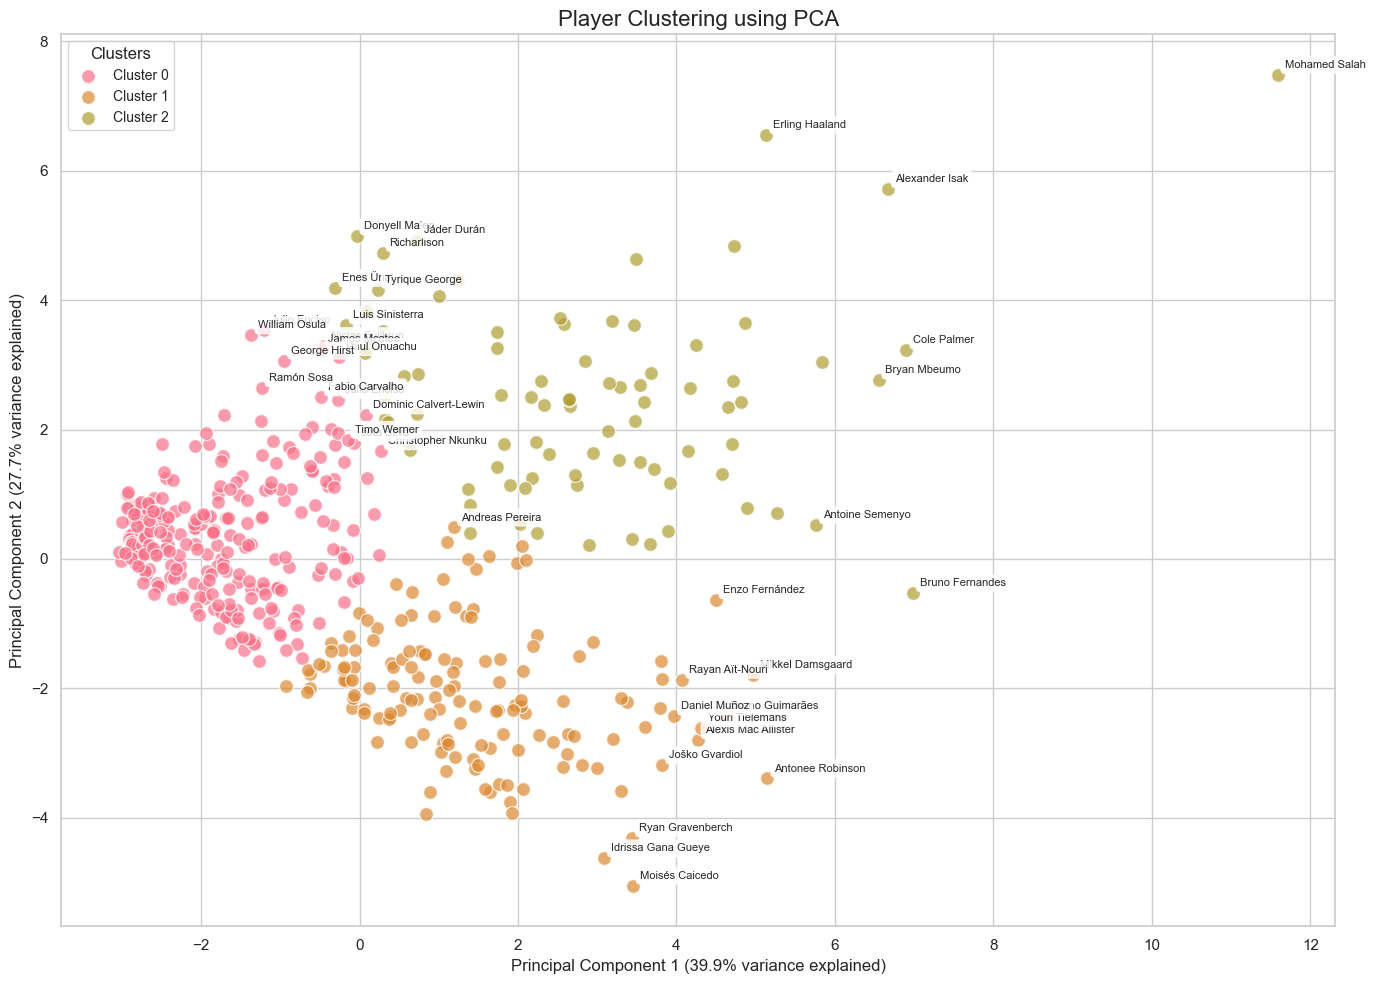

In [18]:
visualize_pca_clusters(X_pca, players, explained_variance)